In [1]:
import torch
from torch import nn

### 1. Save & Load Checkpoint for nn.Module

In [2]:
# 1. Define and instantiate a simple conv 1x1 layer
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

in_planes, out_planes = 64, 256
### --- Please write you code here --- ###
conv1 = conv1x1(in_planes, out_planes, stride=1)
### --- Please write you code here --- ###
print(conv1)

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [3]:
# 3. Observe its weight shape and parameters
print(conv1.weight.shape, conv1.weight)

torch.Size([256, 64, 1, 1]) Parameter containing:
tensor([[[[-0.0833]],

         [[ 0.1050]],

         [[-0.0262]],

         ...,

         [[-0.0519]],

         [[-0.0446]],

         [[-0.0340]]],


        [[[ 0.1107]],

         [[-0.0587]],

         [[ 0.0570]],

         ...,

         [[-0.0453]],

         [[-0.1104]],

         [[ 0.1085]]],


        [[[ 0.0230]],

         [[-0.0056]],

         [[-0.0633]],

         ...,

         [[ 0.1028]],

         [[-0.0011]],

         [[ 0.0742]]],


        ...,


        [[[-0.0037]],

         [[-0.0005]],

         [[ 0.0913]],

         ...,

         [[ 0.0162]],

         [[-0.1198]],

         [[ 0.0639]]],


        [[[-0.0220]],

         [[ 0.0900]],

         [[-0.0969]],

         ...,

         [[ 0.0816]],

         [[ 0.0474]],

         [[-0.1183]]],


        [[[-0.0925]],

         [[-0.1149]],

         [[-0.0386]],

         ...,

         [[ 0.0073]],

         [[-0.0216]],

         [[-0.0421]]]], requir

In [4]:
# 4. We can see the weights are random floats. This is because the convolutional layer is initialized by a special uniform distribution, namely kaiming_uniform_
# (if you are interested in it, please refer to nn.init.kaiming_uniform_)
# Now lets save this weight to a file. What we actually saved for a file its state_dict, which contains the variable name and its values
print(conv1.state_dict())

OrderedDict([('weight', tensor([[[[-0.0833]],

         [[ 0.1050]],

         [[-0.0262]],

         ...,

         [[-0.0519]],

         [[-0.0446]],

         [[-0.0340]]],


        [[[ 0.1107]],

         [[-0.0587]],

         [[ 0.0570]],

         ...,

         [[-0.0453]],

         [[-0.1104]],

         [[ 0.1085]]],


        [[[ 0.0230]],

         [[-0.0056]],

         [[-0.0633]],

         ...,

         [[ 0.1028]],

         [[-0.0011]],

         [[ 0.0742]]],


        ...,


        [[[-0.0037]],

         [[-0.0005]],

         [[ 0.0913]],

         ...,

         [[ 0.0162]],

         [[-0.1198]],

         [[ 0.0639]]],


        [[[-0.0220]],

         [[ 0.0900]],

         [[-0.0969]],

         ...,

         [[ 0.0816]],

         [[ 0.0474]],

         [[-0.1183]]],


        [[[-0.0925]],

         [[-0.1149]],

         [[-0.0386]],

         ...,

         [[ 0.0073]],

         [[-0.0216]],

         [[-0.0421]]]]))])


In [5]:
# 5. Let's save them
### --- Please write you code here --- ###
torch.save(conv1.state_dict(), 'conv1.pt')
### --- Please write you code here --- ###
# now you should can find "conv1.pt" at your current folder

In [6]:
# 6. Let's create a new conv1x1 layer, and compare its weight with original conv1. 
# We can see they are different
conv1_ = conv1x1(in_planes, out_planes, stride=1)
print('All different?', (conv1_.weight != conv1.weight).all())

All different? tensor(True)


In [7]:
# 7. Let's load saved conv1 weight to conv1_. Then they can be the same
conv1_.load_state_dict(torch.load('conv1.pt'))
print('All same?', (conv1_.weight == conv1.weight).all())

All same? tensor(True)


#### Congratulations! Now you have learned how to save a model's weights and load them.

### 2. Build a ResNet from scratch
Residual network (ResNet) (https://arxiv.org/abs/1512.03385) is the most popular convolutional network. Its main idea, "residual skip connection", is widely used in nearly all deep learning models, e.g. Transformers. Here, we learn how to implement it from scratch. Our target is a optimized ResNet (https://catalog.ngc.nvidia.com/orgs/nvidia/resources/resnet_50_v1_5_for_pytorch) called ResNet v1.5, which has a better performance than the vanilla model.

In [10]:
# 1. Define a conv3x3 function
def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )

In [11]:
# 2. Let's create a bottleneck network, which is the basic module residual network (ResNet), and its structure is as follows:
# conv1 -> bn1 -> relu -> conv2 -> bn2 -> relu -> conv3 -> bn3 -> out
#  |                                                        |                                                        
# (shortcut) ---------------(may downsample)------------(shortcut)

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: nn.Module = None,
    ) -> None:
        super().__init__()
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
Bottleneck(64, 64)

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [12]:
# 3. Let's use the module to build the basic layer (block) of the resnet, which we usually call "res1, res2, ..". We first define the _make_layer for more convenient programming

def _make_layer(
    block: Bottleneck,
    inplanes: int,
    planes: int,
    blocks: int,
    stride: int = 1,
) -> tuple:
    downsample = None
    # when applying downsample: stride > 1, or the previous channels (planes) is not equal to the channel in this block
    if stride != 1 or inplanes != planes * block.expansion:
        # downsample: conv1x1 (with stride > 1) -> bn
        ### --- Please write you code here --- ###
        downsample = nn.Sequential(
            conv1x1(inplanes, planes * block.expansion, stride),
            nn.BatchNorm2d(planes * block.expansion),
        )
        ### --- Please write you code here --- ###
    layers = [block(inplanes, planes, stride, downsample)]
    outplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(
            block(
                outplanes,
                planes,
            )
        )

    return nn.Sequential(*layers), outplanes

layer = _make_layer(Bottleneck, 64, 64, 3, stride=1)
print(layer)

(Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, k

In [43]:
# 4. With the bottleneck module, we can build the whole ResNet by reusing the _make_layers function
from typing import Type
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Bottleneck] = Bottleneck,
        layers: list[int] = [3, 4, 6, 3],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        base_width: int = 64,
    ) -> None:
        super().__init__()
        self.inplanes = 64
        self.base_width = base_width
        # image (3 channels) -> conv1 (ksize 7, stride 2, padding3) -> bn1 -> relu -> maxpool (ksize 3, stride 2, padding 1)
        ### --- Please write you code here --- ###
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ### --- Please write you code here --- ###
        self.layer1, inplanes = _make_layer(block, self.inplanes, 64, layers[0])
        self.layer2, inplanes = _make_layer(block, inplanes, 128, layers[1], stride=2)
        self.layer3, inplanes = _make_layer(block, inplanes, 256, layers[2], stride=2)
        self.layer4, inplanes = _make_layer(block, inplanes, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]

    def forward(self, x):
        # conv1 -> bn1 -> relu -> maxpool
        ### --- Please write you code here --- ###
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        ### --- Please write you code here --- ###

        # layer1 -> layer2 -> layer3 -> layer4
        ### --- Please write you code here --- ###
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        ### --- Please write you code here --- ###

        # avgpool -> flatten -> fc 
        ### --- Please write you code here --- ###
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        ### --- Please write you code here --- ###

        return x

resnet = ResNet()

In [44]:
# 5. Let's create a dummy image tensor (1x3x224x224) and pass it into the network, then observe the output
x = torch.rand(1,3,224,224)
resnet = ResNet() # just use its default args
y = resnet(x)
print(y.shape, y)

torch.Size([1, 1000]) tensor([[ 3.9029e-02,  3.2123e-01,  6.6959e-01,  1.0546e-02,  6.7023e-02,
          7.4163e-02, -1.0610e+00, -7.7062e-01,  2.4968e-01,  3.4339e-01,
          4.0400e-02, -3.4637e-02,  4.1113e-01, -3.4429e-01, -9.9668e-01,
         -7.5056e-01, -7.1170e-01,  1.5493e+00,  8.0034e-01,  7.5778e-01,
          8.0465e-01,  2.4016e-01,  1.5220e+00,  2.0916e-01, -1.1082e-01,
          5.9293e-01,  4.1750e-02, -9.3987e-01,  6.5985e-02,  6.5495e-01,
          3.5558e-02, -8.9834e-02, -2.5641e-01,  6.2440e-01,  3.9735e-01,
          3.3746e-01,  7.4797e-01, -7.4088e-01, -8.8812e-02, -4.2119e-01,
          8.0580e-01,  9.6976e-01, -9.6328e-01,  5.6455e-01,  7.7723e-01,
         -3.9794e-01,  1.5736e+00, -1.6972e+00,  2.0841e-01, -1.9186e-01,
         -1.3437e-01, -3.4529e-01,  1.4134e+00, -8.1138e-02,  1.6028e-01,
          1.4901e-02,  5.3757e-02,  2.8575e-01, -2.8942e-01, -2.3754e-01,
         -2.9998e-01,  2.2797e-01,  9.5644e-01, -4.4202e-01,  9.5258e-01,
          2.4788

### 3. Load the Pre-trained ResNet Checkpoint for Image Recognition
Since our ResNet building procedure follows the torchvision's implementation, so we can use its pretrained weights! Please recall what we have learned in save & load a checkpoint.

In [45]:
# 1. Load checkpoint to resnet:
from torchvision.models import ResNet50_Weights
weights = ResNet50_Weights.verify('DEFAULT')
pretrained_state_dict = weights.get_state_dict(progress=True)
### --- Please write you code here --- ###
resnet.load_state_dict(pretrained_state_dict)
### --- Please write you code here --- ###

<All keys matched successfully>

c:\Users\ChenJoya\miniconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Persian cat: 37.4%
Angora: 0.8%
cardigan: 0.7%
lynx: 0.5%
jean: 0.3%
sock: 0.3%
hamper: 0.3%
mitten: 0.3%
ski mask: 0.3%
window screen: 0.2%
window shade: 0.2%
wool: 0.2%
remote control: 0.2%
bonnet: 0.2%
teddy: 0.2%
patas: 0.2%
Pomeranian: 0.2%
poncho: 0.2%
nipple: 0.2%
bow tie: 0.2%
Egyptian cat: 0.2%
dumbbell: 0.2%
pillow: 0.2%
feather boa: 0.2%
stole: 0.2%
bib: 0.2%
tiger cat: 0.2%
Japanese spaniel: 0.2%
studio couch: 0.1%
refrigerator: 0.1%
theater curtain: 0.1%
cup: 0.1%
tabby: 0.1%
quilt: 0.1%
wardrobe: 0.1%
washbasin: 0.1%
caldron: 0.1%
table lamp: 0.1%
Maltese dog: 0.1%
laptop: 0.1%
lens cap: 0.1%
Siamese cat: 0.1%
Arctic fox: 0.1%
cowboy hat: 0.1%
mosquito net: 0.1%
shoji: 0.1%
hare: 0.1%
home theater: 0.1%
space heater: 0.1%
hay: 0.1%
chain mail: 0.1%
buckle: 0.1%
plastic bag: 0.1%
four-poster: 0.1%
radiator: 0.1%
wok: 0.1%
purse: 0.1%
bald eagle: 0.1%
bubble: 0.1%
titi: 0.1%
pajama: 0.1%
bulbul: 0.1%
Scotch terrier: 0.1%
prayer rug: 0.1%
notebook: 0.1%
polecat: 0.1%
tennis 

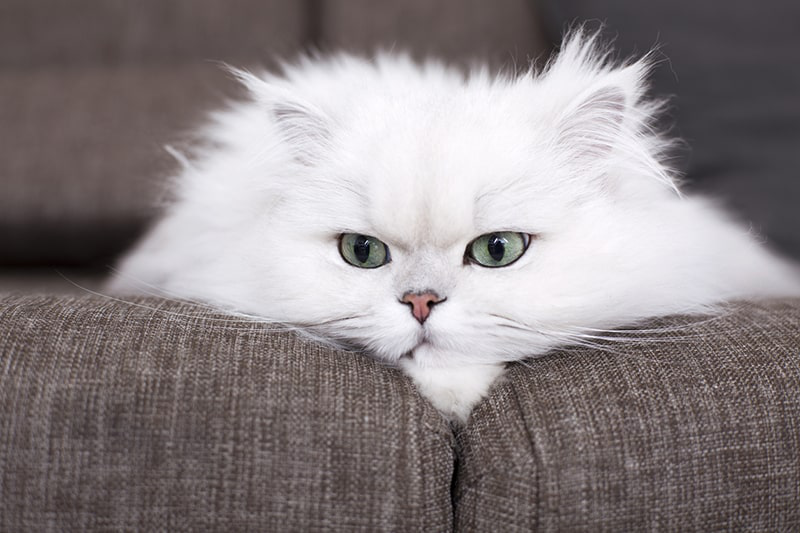

In [46]:
# 7. let's load an image and use the model to classify its category!
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

preprocess = weights.transforms()
def classify(image_path):
    image = read_image(image_path)
    x = preprocess(image).unsqueeze(0)
    resnet.eval()

    with torch.inference_mode():
        # forward x, and obtain the scores over 1000 classes
        ### --- Please write you code here --- ###
        scores = resnet(x).softmax(dim=-1).squeeze_()
        ### --- Please write you code here --- ###
    sorted_ids = scores.argsort(descending=True).tolist()
    for class_id in sorted_ids:
        score = scores[class_id].item()
        category_name = weights.meta["categories"][class_id]
        print(f"{category_name}: {100 * score:.1f}%")
    display(to_pil_image(image))

classify('demo.jpg')

### 4. Finetuning ResNet to a 10-class classification network
In this section, we learn to how fine-tune a pretrained model to a specific domain. Our task is to fine-tune ResNet to classify 10 categories in CIFAR-10 dataset.
(NOTE: its only for demonstrating, thus cannot achieve the best performance. If you are interested in them, please find more information in PyTorch Tutorial.)

In [47]:
# 1. Download MNIST datasets. Here we apply a resize CIFAR input size 32x32 -> 224x224, to fit ResNet's input size
from torchvision.datasets.cifar import CIFAR10
from torchvision.models.resnet import ImageClassification
train_data = CIFAR10('./', train=True, transform=ImageClassification(crop_size=224, resize_size=224), download=True)
test_data = CIFAR10('./', train=False, transform=ImageClassification(crop_size=224, resize_size=224), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
# 2. Define dataloader. We use a batch size = 16
batch_size = 16
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True) # not use here

In [73]:
# 3. Adjust the output of ResNet, and make it only input 1 logit. After sigmoid(logit) to get the score. 
# If an image gets obtains larger than 0.5, we consider it as a cat, otherwise a dog.
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 10)

In [74]:
# 4. Prepare to tune the new layer. We frozen all parameters of resnet except resnet.fc
resnet.requires_grad_(False)
resnet.fc.requires_grad_(True)

Linear(in_features=2048, out_features=10, bias=True)

In [75]:
# 5. We use momentum SGD to optimize the model
learning_rate = 0.001
from torch.optim import SGD
optimizer = SGD(resnet.parameters(), learning_rate, momentum=0.9)

In [76]:
# 6. Finetuning the model for 50 iterations
from torch.functional import F
num_iters = 50
for i, (images, labels) in enumerate(train_dataloader):
    if i >= num_iters:
        break
    optimizer.zero_grad()
    preds = resnet(images)
    loss = F.cross_entropy(preds, labels)
    print(f'iter {i+1} / {num_iters}, loss {loss.item()}, top-1 acc in this batch {(preds.argmax(dim=-1) == labels).sum() / labels.numel()}...')
    loss.backward()
    optimizer.step()

iter 1 / 50, loss 2.3740618228912354, top-1 acc in this batch 0.125...
iter 2 / 50, loss 2.389463186264038, top-1 acc in this batch 0.125...
iter 3 / 50, loss 2.2180614471435547, top-1 acc in this batch 0.375...
iter 4 / 50, loss 2.2805941104888916, top-1 acc in this batch 0.1875...
iter 5 / 50, loss 2.3282899856567383, top-1 acc in this batch 0.125...
iter 6 / 50, loss 2.264596462249756, top-1 acc in this batch 0.125...
iter 7 / 50, loss 2.278656482696533, top-1 acc in this batch 0.0625...
iter 8 / 50, loss 2.3022923469543457, top-1 acc in this batch 0.25...
iter 9 / 50, loss 2.266883611679077, top-1 acc in this batch 0.125...
iter 10 / 50, loss 2.2385921478271484, top-1 acc in this batch 0.0625...
iter 11 / 50, loss 2.0868771076202393, top-1 acc in this batch 0.3125...
iter 12 / 50, loss 2.2256927490234375, top-1 acc in this batch 0.1875...
iter 13 / 50, loss 2.246983051300049, top-1 acc in this batch 0.125...
iter 14 / 50, loss 2.135666608810425, top-1 acc in this batch 0.25...
iter

#### Congratulations! You have learned (1) how to save & load a model; (2) how to build a complex network (ResNet) from scratch; and (3) Load pre-trained weights to ResNet and do inference; (4) Finetuning ResNet on a small set of images!